## Predicting whether a credit card client will default or not

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets 
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV 

from sklearn.model_selection import ( 
    GridSearchCV, 
    RandomizedSearchCV, 
    ShuffleSplit, 
    cross_val_score, 
    cross_validate, 
    train_test_split, 
) 
 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import ( 
    OneHotEncoder, 
    OrdinalEncoder, 
    PolynomialFeatures, 
    StandardScaler 
) 
from sklearn.svm import SVC 
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier 
 
from sklearn.metrics import ( 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score, 
    ConfusionMatrixDisplay, 
    precision_recall_curve, 
    PrecisionRecallDisplay, 
    roc_curve, 
    roc_auc_score 
) 

from scipy.stats import loguniform, randint
import shap 

from itertools import combinations

%matplotlib inline

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

## 1. Aim

The aim of this project is to predict whether a credit card client will default (fail to pay) their payment or not. This is a classification problem.

<br>

## 2. Data

The data used in this project can be found publicly on [Kaggle - Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). There are 30,000 observations and 42 features in this data set.

In the next steps, the code assumes that the data file is stored as `UCI_Credit_Card.csv` in the project root.

<br>

## 3. EDA

First, let us have a look at the data set more closely.

In [3]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
df.info()

(30000, 25)
0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BIL

In [ ]:
print(df["default.payment.next.month"].value_counts(normalize=True))

<br>

First, we notice that the data set has **no missing values** which is good since this means no imputation is required. However, there is **class imbalance** present with only 0.2212 of the observations corresponding to a default payment. Since we are more interested in predicting default payments, we would need to deal with class imbalance.

A false negative in this problem corresponds to the model predicting a payment as not default when it actually is whereas a false positive corresponds to a prediction of default when it actually is not. Thus, a false negative is more harmful because it may affect the decision of the bank to increase a customer's credit when they are not able to make payments in time. To control for the number of false negative (Type II error), we need to **look at the recall**.

In terms of the features, **most are numeric**, with the exception of `SEX` (**binary** variable), `EDUCATION` (**ordinal** variable), `MARRIAGE` (**categorical** variable), and `PAY_X` variables where X denotes a number from 0, and 2 to 6 (**ordinal** variable). 

Furethermore, as per [discussion on Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/discussion/34608), the `MARRIAGE` feature was **not documented correctly** according to the data set's creator. Thus, `MARRIAGE` will be dropped during pre-processing.

The target column `default.payment.next.month` is shortened to `default`. Additionally, the column `PAY_0` is renamed to `PAY_1` so that it is aligned with the `PAY_AMTX` variables.

In [5]:
df = df.rename(columns={
    "default.payment.next.month": "default",
    "PAY_0": "PAY_1"
})
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

In [6]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.shape

(21000, 25)

In [7]:
test_df.shape

(9000, 25)

<br>

The train set has 21,000 observations and the test set has 9,000 observations after a **70/30 split**.

<br><br>

## 4. More EDA

In [8]:
train_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,14962.348238,167880.651429,1.600762,1.852143,1.554000,35.500810,-0.015429,-0.137095,-0.171619,-0.225238,...,43486.610905,40428.518333,38767.202667,5673.585143,5.895027e+03,5311.432286,4774.021381,4751.850095,5237.762190,0.223238
std,8650.734050,130202.682167,0.489753,0.792961,0.521675,9.212644,1.120465,1.194506,1.196123,1.168556,...,64843.303993,61187.200817,59587.689549,17033.241454,2.180143e+04,18377.997079,15434.136142,15228.193125,18116.846563,0.416427
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-50616.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7498.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2293.750000,1739.500000,1215.750000,1000.000000,8.200000e+02,390.000000,266.000000,234.000000,110.750000,0.000000
50%,14960.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19102.500000,18083.000000,16854.500000,2100.000000,2.007000e+03,1809.500000,1500.000000,1500.000000,1500.000000,0.000000
75%,22458.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54763.250000,50491.000000,49253.750000,5007.250000,5.000000e+03,4628.500000,4021.250000,4016.000000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [9]:
train_df.groupby(by="default").aggregate(["mean", "std"])["LIMIT_BAL"]

,mean,std
default,,
0,178297.940167,132225.852417
1,131633.464164,115831.120526


In [10]:
train_df.groupby(by="default").aggregate(["mean", "std"])["PAY_AMT1"]

,mean,std
default,,
0,6327.043097,18613.931898
1,3399.863695,9351.216540


<br>

From the mean and standard deviation summary shown above, the feature `LIMIT_BAL` descirbes the **amount of given credit** in NT dollars, and a `default` of 1 represents as a default payment. The standard deviations of the `LIMIT_BAL` feature is large for both groups so it is not immediately obvious what the relationship between the feature and the target is.

The feature `PAY_AMT1` describes the **bill statement amount** in September 2005. Again, the standard deviations of the `PAY_AMT1` feature is large for both groups so it is not immediately obvious what the relationship between the feature and the target is. However, it is important to remember that looking at features in isolation may not always reveal important characteristics of the features.

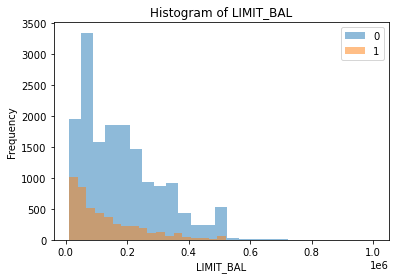

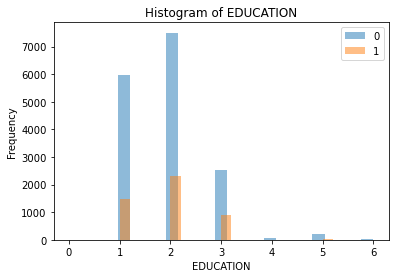

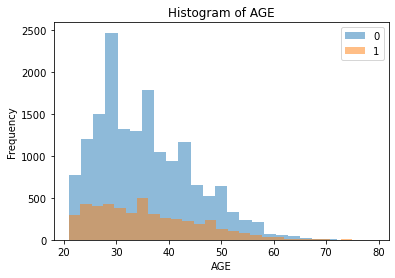

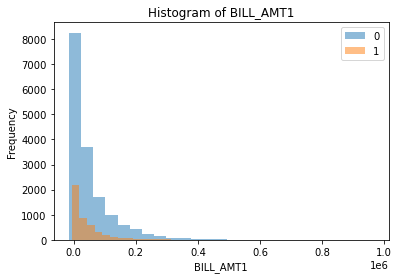

In [11]:
viz_features = ["LIMIT_BAL", "EDUCATION", "AGE", "BILL_AMT1"]

for idx, feat in enumerate(viz_features):
    ax = (train_df.groupby("default")[feat].plot.hist(bins=25, alpha=0.5, legend=True))
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

<br>

From the histogram of the feature `LIMIT_BAL`, it appears that a larger proportion of default payments are found when the value of `LIMIT_BAL` is smaller. The distributions of the other numeric features are roughly the same for both classes. However, it is important to remember that looking at features in isolation may not always reveal important characteristics or trends.


In [12]:
print(train_df["default"].value_counts(normalize=True))

0    0.776762
1    0.223238
Name: default, dtype: float64


<br>

Since we have a classification problem with **class imbalance**, the accuracy metric is not sufficient and can be misleading. Thus, additional metrics like the recall and f1 score are used to observe the number of false positives and false negatives.

In [ ]:
scoring_metrics = ["accuracy", "recall", "f1", "roc_auc", "average_precision"]

<br><br>

## 5. Feature engineering

The `BILL_AMT_X` features describe the amount of bill statements for different months `X`. The `PAY_X` features describe the repayment status for different months `X`. A value of 1 indicates that the client delayed the payment for one month, 2 indicates a delay of two months, 0 indicates the use of revolving credit, -1 indicates that the bill was paid in full and -2 indicates no consumption.

Thus, new features corresponding to how much the bill statement was and the repayment status are engineered. A very large negative value indicates that the client is able to pay a large bill statement on time, which could suggest that the client is trustworthy and unlikely to default their payment. On the other hand, large and positive values indicate that the client is unable to make payments on time.

In [14]:
for i in range(1, 7):
    train_df['AMT_DELAY' + str(i)] = train_df["PAY_" +
                                              str(i)] * train_df["BILL_AMT" + str(i)]
    test_df['AMT_DELAY' + str(i)] = test_df["PAY_" +
                                            str(i)] * test_df["BILL_AMT" + str(i)]

<br><br>

## 6. Preprocessing and transformations

The features are pre-processed and transformed based on the data type. Numeric features are scaled, and binary features undergo one hot encoding.

In [15]:
X_train = train_df.drop(columns=["default"])
y_train = train_df["default"]

X_test = test_df.drop(columns=["default"])
y_test = test_df["default"]

In [16]:
drop_features = ["ID", "MARRIAGE"]
numeric_features = ["LIMIT_BAL", "AGE", "BILL_AMT1",
                    "BILL_AMT2", "BILL_AMT3", "BILL_AMT4",
                    "BILL_AMT5", "BILL_AMT6", "PAY_AMT1",
                    "PAY_AMT2", "PAY_AMT3", "PAY_AMT4",
                    "PAY_AMT5", "PAY_AMT6", "AMT_DELAY1",
                    "AMT_DELAY2", "AMT_DELAY3", "AMT_DELAY4",
                    "AMT_DELAY5", "AMT_DELAY6"]
binary_features = ["SEX"]
passthrough_features = ["EDUCATION", "PAY_1", "PAY_2", "PAY_3",
                        "PAY_4", "PAY_5", "PAY_6"]

assert set(X_train.columns) == set(drop_features +
                                   numeric_features + binary_features + passthrough_features)

# None of the features have missing values
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features)
)

<br><br>

## 7. Baseline model

In [17]:
results = {}
results["Baseline"] = mean_std_cross_val_scores(
    DummyClassifier(), X_train, y_train,
    scoring=scoring_metrics,
    return_train_score=True
)

pd.DataFrame(results)

,Baseline
fit_time,0.003 (+/- 0.002)
score_time,0.006 (+/- 0.001)
test_accuracy,0.777 (+/- 0.000)
train_accuracy,0.777 (+/- 0.000)
test_recall,0.000 (+/- 0.000)
train_recall,0.000 (+/- 0.000)
test_f1,0.000 (+/- 0.000)
train_f1,0.000 (+/- 0.000)
test_roc_auc,0.500 (+/- 0.000)
train_roc_auc,0.500 (+/- 0.000)


<br>

The baseline model is the `DummyClassifier` and it has an accuracy of 0.777 because this corresponds to the most frequent class (`default=0`), which has a proportion of 0.777.

<br><br>

## 8. Logistic Regression

In [18]:
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=2000, random_state=123)
)

param_grid = {
    "logisticregression__C": loguniform(1e-1, 1e3),
    "logisticregression__class_weight": ["balanced", None],
}

random_search_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_grid,
    scoring=scoring_metrics,
    refit="roc_auc",
    n_jobs=-1,
    n_iter=100,
    cv=5,
    random_state=123,
    return_train_score=True
)

random_search_lr.fit(X_train, y_train)
results_rs_lr = pd.DataFrame(random_search_lr.cv_results_)

In [19]:
columns = ["mean_fit_time", "mean_score_time",
           "mean_test_roc_auc", "mean_test_average_precision",
           "mean_test_f1", "mean_test_recall",
           "mean_test_accuracy", "param_logisticregression__C",
           "param_logisticregression__class_weight"]

subset_results = results_rs_lr.set_index("rank_test_roc_auc").sort_index()[columns]
subset_results[:5]

,mean_fit_time,mean_score_time,mean_test_roc_auc,mean_test_average_precision,mean_test_f1,mean_test_recall,mean_test_accuracy,param_logisticregression__C,param_logisticregression__class_weight
rank_test_roc_auc,,,,,,,,,
1,0.266615,0.036165,0.735765,0.513270,0.501600,0.630332,0.720286,23.863136,balanced
2,0.300739,0.039182,0.735764,0.513275,0.501685,0.630545,0.720286,66.044297,balanced
3,0.327641,0.042958,0.735763,0.513279,0.501685,0.630545,0.720286,61.076866,balanced
4,0.249687,0.034981,0.735763,0.513272,0.501601,0.630332,0.720286,59.376279,balanced
5,0.251519,0.033720,0.735763,0.513278,0.501771,0.630545,0.720381,478.112943,balanced


In [20]:
print(random_search_lr.best_params_)
print(random_search_lr.best_score_)

{'logisticregression__C': 23.863136077647585, 'logisticregression__class_weight': 'balanced'}
0.7357650152479124


In [21]:
pipe_lr_opt = make_pipeline(
    preprocessor,
    LogisticRegression(
        C=random_search_lr.best_params_["logisticregression__C"],
        class_weight=random_search_lr
        .best_params_["logisticregression__class_weight"],
        max_iter=2000, random_state=123)
)

results["Logistic Regression"] = mean_std_cross_val_scores(
    pipe_lr_opt, X_train, y_train,
    scoring=scoring_metrics,
    return_train_score=True
)

pd.DataFrame(results)

,Baseline,Logistic Regression
fit_time,0.003 (+/- 0.002),0.090 (+/- 0.009)
score_time,0.006 (+/- 0.001),0.018 (+/- 0.001)
test_accuracy,0.777 (+/- 0.000),0.720 (+/- 0.009)
train_accuracy,0.777 (+/- 0.000),0.720 (+/- 0.005)
test_recall,0.000 (+/- 0.000),0.630 (+/- 0.011)
train_recall,0.000 (+/- 0.000),0.632 (+/- 0.001)
test_f1,0.000 (+/- 0.000),0.502 (+/- 0.008)
train_f1,0.000 (+/- 0.000),0.502 (+/- 0.004)
test_roc_auc,0.500 (+/- 0.000),0.736 (+/- 0.009)
train_roc_auc,0.500 (+/- 0.000),0.738 (+/- 0.002)


<br>

The hyperparameter `C` of `LogisticRegression` is the inverse of the regularization strength and the set of hyperparameters that resulted in the highest validation ROC AUC is `C=23.86` and `class_weight="balanced"`.

The `LogisticRegression` model resulted in larger fit and score times, however, **all scoring metrics increased** compared to the baseline model which is a good sign because the `LogisticRegression` model is performing better than the baseline. Furthermore, the gap between the train and validation scores for all scoring metrics is small which suggests that the model did not overfit to the train set. This is good because it implies that hyperparameter optimisation worked in ensuring that our model has **good generalization**.

A false negative in this problem is more harmful because it may affect the decision of the bank to increase a customer's credit when they are not actually able to make payments in time. To control for the number of false negatives (Type-II error), we would need to look at the recall. However, the **recall for our model is still quite low** with a validation score of 0.63 which implies that there is still a relatively large proportion of false negatives. Other non-linear models which can map the features to the target in a non-linear fashion may increase the recall and will be further explored below.

<br><br>

## 9. Non-linear models

Next, four tree ensemble models are explored.

In [22]:
models = {
    "Random Forest": make_pipeline(
        preprocessor,
        RandomForestClassifier(random_state=123)
    ),
    "XGB": make_pipeline(
        preprocessor,
        XGBClassifier(random_state=123,
                      eval_metric="logloss",
                      use_label_encoder=False,
                      verbosity=0)
    ),
    "LGBM": make_pipeline(
        preprocessor,
        LGBMClassifier(random_state=123)
    ),
    "CatBoost": make_pipeline(
        preprocessor,
        CatBoostClassifier(random_state=123, verbose=0)
    )
}

for name, pipeline in models.items():
    results[name] = mean_std_cross_val_scores(
        pipeline, X_train, y_train,
        scoring=scoring_metrics,
        return_train_score=True
    )

pd.DataFrame(results)

,Baseline,Logistic Regression,Random Forest,XGB,LGBM,CatBoost
fit_time,0.003 (+/- 0.002),0.090 (+/- 0.009),3.931 (+/- 0.358),1.667 (+/- 0.280),0.271 (+/- 0.136),3.425 (+/- 0.167)
score_time,0.006 (+/- 0.001),0.018 (+/- 0.001),0.154 (+/- 0.023),0.026 (+/- 0.002),0.031 (+/- 0.002),0.018 (+/- 0.000)
test_accuracy,0.777 (+/- 0.000),0.720 (+/- 0.009),0.812 (+/- 0.005),0.812 (+/- 0.006),0.818 (+/- 0.004),0.819 (+/- 0.004)
train_accuracy,0.777 (+/- 0.000),0.720 (+/- 0.005),0.999 (+/- 0.000),0.903 (+/- 0.005),0.855 (+/- 0.001),0.864 (+/- 0.002)
test_recall,0.000 (+/- 0.000),0.630 (+/- 0.011),0.370 (+/- 0.013),0.367 (+/- 0.011),0.372 (+/- 0.012),0.374 (+/- 0.010)
train_recall,0.000 (+/- 0.000),0.632 (+/- 0.001),0.998 (+/- 0.001),0.616 (+/- 0.020),0.460 (+/- 0.008),0.485 (+/- 0.007)
test_f1,0.000 (+/- 0.000),0.502 (+/- 0.008),0.468 (+/- 0.012),0.465 (+/- 0.014),0.478 (+/- 0.009),0.479 (+/- 0.011)
train_f1,0.000 (+/- 0.000),0.502 (+/- 0.004),0.998 (+/- 0.000),0.739 (+/- 0.016),0.586 (+/- 0.006),0.614 (+/- 0.006)
test_roc_auc,0.500 (+/- 0.000),0.736 (+/- 0.009),0.756 (+/- 0.004),0.759 (+/- 0.008),0.774 (+/- 0.009),0.779 (+/- 0.006)
train_roc_auc,0.500 (+/- 0.000),0.738 (+/- 0.002),1.000 (+/- 0.000),0.957 (+/- 0.007),0.901 (+/- 0.003),0.896 (+/- 0.003)


The `LGBMClassifier` and `CatBoostClassifier` resulted in the highest validation accuracy, while the `LogisticRegression` model after hyperparameter optimisation resulted in the highest validation recall and f1 scores. Additionally, the `CatBoostClassifier` resulted in the highest validation ROC AUC and average precision scores.

This is likely because the `LogisticRegression` model was tuned with ROC AUC as the main scoring metric and not accuracy. On the other hand, the other non-linear models were trained such that the test accuracy is high. In later steps (Exercise 10), hyperparameter optimisation will also be carried out for the non-linear models.

In terms of the run times, excluding the baseline model, the `LogisticRegression` model has the fastest fit time, followed by `LGBMClassifier`, and the `LogisticRegression` model also has the fastest score time followed by `CatBoostClassifier`.

All the non-linear models experience overfitting as reflected by the large gap between train and validation scores for all scoring metrics. This is likely because hyperparameters are not tuned for these models.

Thus, using default hyperparameters for the non-linear models resulted in worse performance than the tuned `LogisticRegression` model. However, it remains unexplored whether the non-linear models will outperform the linear modle after hyperparameter optimisation.

<br><br>

## 10. Feature selection

To reduce the risk of overfitting, recursive feature elimination is performed, and model performances are compared to see whether there are any significant improvements.

In [23]:
results_lr = {}
results_lr["Logistic Regression"] = results["Logistic Regression"]

pipe_rfe_lr = make_pipeline(
    preprocessor,
    RFECV(LogisticRegression(solver="liblinear", max_iter=2000, random_state=123),
          cv=5, scoring="roc_auc"),
    LogisticRegression(solver="liblinear", max_iter=2000, random_state=123)
)

param_grid = {
    "logisticregression__C": loguniform(1e-1, 1e3),
    "logisticregression__class_weight": ["balanced", None],
    "logisticregression__penalty": ["l1", "l2"]
}

random_search_lr_rfe = RandomizedSearchCV(
    pipe_rfe_lr,
    param_distributions=param_grid,
    scoring=scoring_metrics,
    refit="roc_auc",
    n_jobs=-1,
    n_iter=20,
    cv=5,
    random_state=123,
    return_train_score=True
)

random_search_lr_rfe.fit(X_train, y_train)
results_rs_lr_rfe = pd.DataFrame(random_search_lr_rfe.cv_results_)

In [24]:
print(random_search_lr_rfe.best_params_)
print(random_search_lr_rfe.best_score_)

{'logisticregression__C': 34.4829040891314, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l2'}
0.7358238596226769


In [25]:
pipe_lr_opt = make_pipeline(
    preprocessor,
    RFECV(LogisticRegression(solver="liblinear", max_iter=2000, random_state=123),
          cv=5, scoring="roc_auc"),
    LogisticRegression(
        C=random_search_lr_rfe.best_params_["logisticregression__C"],
        class_weight=random_search_lr_rfe
        .best_params_["logisticregression__class_weight"],
        solver="liblinear",
        penalty=random_search_lr_rfe.best_params_["logisticregression__penalty"],
        max_iter=2000, random_state=123)
)

results_lr["Logistic Regression + RFECV"] = mean_std_cross_val_scores(
    pipe_lr_opt, X_train, y_train,
    scoring=scoring_metrics,
    return_train_score=True
)

pd.DataFrame(results_lr)

,Logistic Regression,Logistic Regression + RFECV
fit_time,0.090 (+/- 0.009),5.629 (+/- 0.197)
score_time,0.018 (+/- 0.001),0.018 (+/- 0.000)
test_accuracy,0.720 (+/- 0.009),0.720 (+/- 0.009)
train_accuracy,0.720 (+/- 0.005),0.720 (+/- 0.005)
test_recall,0.630 (+/- 0.011),0.630 (+/- 0.012)
train_recall,0.632 (+/- 0.001),0.631 (+/- 0.002)
test_f1,0.502 (+/- 0.008),0.501 (+/- 0.008)
train_f1,0.502 (+/- 0.004),0.502 (+/- 0.004)
test_roc_auc,0.736 (+/- 0.009),0.736 (+/- 0.009)
train_roc_auc,0.738 (+/- 0.002),0.738 (+/- 0.002)


In [26]:
print(f"Feature selection caused the number of features to " 
      f"decrease from {len(X_train.columns)} to " 
      f"{sum(random_search_lr_rfe.best_estimator_.named_steps['rfecv'].support_)}.")

print("\nThe features removed after feature selection are:")
set(X_train.columns) - set(
    [_.split("__")[1] for _ in
     (random_search_lr_rfe.best_estimator_
      .named_steps['columntransformer']
      .get_feature_names_out()[
          (random_search_lr_rfe.best_estimator_
           .named_steps["rfecv"].support_)])] 
) - set(drop_features) 

Feature selection caused the number of features to decrease from 30 to 23.

The features removed after feature selection are:


{'AMT_DELAY3', 'BILL_AMT6', 'PAY_5', 'PAY_6', 'PAY_AMT5', 'SEX'}

<br>

After feature selection using `RFECV`, there is no difference in the results for any of the validation scoring metrics. However, the **fit time increased** by a factor of about 60. Thus, **feature selection is removed from the pipeline** for the subsequent steps.

<br><br>

## 11. Hyperparameter optimisation of Random Forest and LGBMClassifier

In [27]:
pipe_lgbm = make_pipeline(
    preprocessor,
    LGBMClassifier(random_state=123)
)

param_grid = {
    "lgbmclassifier__max_depth": randint(low=-1, high=100),
    "lgbmclassifier__learning_rate": loguniform(1e-3, 1e0),
    "lgbmclassifier__min_child_samples": randint(low=10, high=50),
    "lgbmclassifier__reg_lambda": loguniform(1e0, 1e2)
}

random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_distributions=param_grid,
    scoring=scoring_metrics,
    refit="roc_auc",
    n_jobs=-1,
    n_iter=200,
    cv=5,
    random_state=123,
    return_train_score=True,
    verbose=0
)

random_search_lgbm.fit(X_train, y_train)
results_rs_lgbm = pd.DataFrame(random_search_lgbm.cv_results_)

In [28]:
columns = ["mean_fit_time", "mean_score_time",
           "mean_test_roc_auc", "mean_test_average_precision",
           "mean_test_f1", "mean_test_recall",
           "mean_test_accuracy", "param_lgbmclassifier__learning_rate",
           "param_lgbmclassifier__max_depth", 
           "param_lgbmclassifier__min_child_samples", 
           "param_lgbmclassifier__reg_lambda"]

subset_results = results_rs_lgbm.set_index("rank_test_roc_auc").sort_index()[columns]
subset_results[:5]

,mean_fit_time,mean_score_time,mean_test_roc_auc,mean_test_average_precision,mean_test_f1,mean_test_recall,mean_test_accuracy,param_lgbmclassifier__learning_rate,param_lgbmclassifier__max_depth,param_lgbmclassifier__min_child_samples,param_lgbmclassifier__reg_lambda
rank_test_roc_auc,,,,,,,,,,,
1,0.638062,0.118232,0.783001,0.567473,0.474214,0.362841,0.820381,0.030653,54,35,7.476896
2,0.717950,0.135664,0.782771,0.568009,0.470122,0.358361,0.819667,0.032726,58,19,14.49481
3,0.671694,0.126800,0.782725,0.567153,0.474853,0.362841,0.820857,0.02826,79,49,1.366122
4,0.716293,0.134043,0.782669,0.566980,0.471387,0.360279,0.819619,0.043688,41,28,35.400956
5,0.624634,0.113082,0.782525,0.568111,0.474461,0.363480,0.820238,0.03631,72,27,13.395594


In [29]:
print(random_search_lgbm.best_params_)
print(random_search_lgbm.best_score_)

{'lgbmclassifier__learning_rate': 0.030653167831444797, 'lgbmclassifier__max_depth': 54, 'lgbmclassifier__min_child_samples': 35, 'lgbmclassifier__reg_lambda': 7.476895754268584}
0.783000773136306


In [30]:
# Only one hyperparameter is tuned becasue it takes a long time to run
pipe_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=123)
)

param_grid = {
    "randomforestclassifier__max_depth": randint(low=1, high=200)
}

random_search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_grid,
    scoring=scoring_metrics,
    refit="roc_auc",
    n_jobs=-1,
    n_iter=20,
    cv=5,
    random_state=123,
    return_train_score=True,
    verbose=0
)

random_search_rf.fit(X_train, y_train)
results_rs_rf = pd.DataFrame(random_search_rf.cv_results_)

In [31]:
pipe_lgbm_opt = make_pipeline(
    preprocessor,
    LGBMClassifier(
        max_depth=random_search_lgbm.best_params_["lgbmclassifier__max_depth"],
        learning_rate=random_search_lgbm.best_params_["lgbmclassifier__learning_rate"],
        min_child_samples=random_search_lgbm.best_params_["lgbmclassifier__min_child_samples"],
        reg_lambda=random_search_lgbm.best_params_["lgbmclassifier__reg_lambda"],
        random_state=123)
)

pipe_lgbm_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(
        max_depth=random_search_rf.best_params_["randomforestclassifier__max_depth"],
        random_state=123)
)

results["LGBM tuned"] = mean_std_cross_val_scores(
    pipe_lgbm_opt, X_train, y_train,
    scoring=scoring_metrics,
    return_train_score=True
)

results["Random Forest tuned"] = mean_std_cross_val_scores(
    pipe_lgbm_rf, X_train, y_train,
    scoring=scoring_metrics,
    return_train_score=True
)

pd.DataFrame(results)

,Baseline,Logistic Regression,Random Forest,XGB,LGBM,CatBoost,LGBM tuned,Random Forest tuned
fit_time,0.003 (+/- 0.002),0.090 (+/- 0.009),3.931 (+/- 0.358),1.667 (+/- 0.280),0.271 (+/- 0.136),3.425 (+/- 0.167),0.290 (+/- 0.123),3.087 (+/- 0.085)
score_time,0.006 (+/- 0.001),0.018 (+/- 0.001),0.154 (+/- 0.023),0.026 (+/- 0.002),0.031 (+/- 0.002),0.018 (+/- 0.000),0.031 (+/- 0.003),0.114 (+/- 0.003)
test_accuracy,0.777 (+/- 0.000),0.720 (+/- 0.009),0.812 (+/- 0.005),0.812 (+/- 0.006),0.818 (+/- 0.004),0.819 (+/- 0.004),0.820 (+/- 0.006),0.817 (+/- 0.003)
train_accuracy,0.777 (+/- 0.000),0.720 (+/- 0.005),0.999 (+/- 0.000),0.903 (+/- 0.005),0.855 (+/- 0.001),0.864 (+/- 0.002),0.827 (+/- 0.001),0.928 (+/- 0.002)
test_recall,0.000 (+/- 0.000),0.630 (+/- 0.011),0.370 (+/- 0.013),0.367 (+/- 0.011),0.372 (+/- 0.012),0.374 (+/- 0.010),0.363 (+/- 0.013),0.365 (+/- 0.012)
train_recall,0.000 (+/- 0.000),0.632 (+/- 0.001),0.998 (+/- 0.001),0.616 (+/- 0.020),0.460 (+/- 0.008),0.485 (+/- 0.007),0.378 (+/- 0.007),0.681 (+/- 0.007)
test_f1,0.000 (+/- 0.000),0.502 (+/- 0.008),0.468 (+/- 0.012),0.465 (+/- 0.014),0.478 (+/- 0.009),0.479 (+/- 0.011),0.474 (+/- 0.015),0.471 (+/- 0.009)
train_f1,0.000 (+/- 0.000),0.502 (+/- 0.004),0.998 (+/- 0.000),0.739 (+/- 0.016),0.586 (+/- 0.006),0.614 (+/- 0.006),0.493 (+/- 0.006),0.809 (+/- 0.005)
test_roc_auc,0.500 (+/- 0.000),0.736 (+/- 0.009),0.756 (+/- 0.004),0.759 (+/- 0.008),0.774 (+/- 0.009),0.779 (+/- 0.006),0.783 (+/- 0.007),0.770 (+/- 0.005)
train_roc_auc,0.500 (+/- 0.000),0.738 (+/- 0.002),1.000 (+/- 0.000),0.957 (+/- 0.007),0.901 (+/- 0.003),0.896 (+/- 0.003),0.830 (+/- 0.002),0.987 (+/- 0.001)


After hyperparameter optimisation of the `LGBMClassifier`, the validation accuracy, ROC AUC, and average precision scores improved. Furthermore, the gap between the train and validation scores become smaller which suggests that the **model is not overfitting to the train set as much**. However, as a result of maximising the ROC AUC, the recall and f1-score decreased.

After hyperparameter optimisation of the `RandomForestClassifier`, the validation accuracy, f1-score, ROC AUC, and average precision scores improved. However, the gap between the train and validation scores are still large which suggests that the model is still overfitting to the train set. This is likely because hyperparameter optimisation was carried out only for one hyperparameter.

The `RandomForestClassifier` seems to overfit to the training data more than the `LGBMClassifier`, and the `LGBMClassifier` also outperforms the `RandomForestClassifier` on the ROC AUC, average precision, and f1-score. Thus, the `LGBMClassifier` is used as the final model.

<br><br>

## 12. Model interpretation and feature importances

SHAP values are used to interpret the model and examine feature importances.

In [32]:
feature_names = [
    _.split("__")[1] for _ in
    (random_search_lgbm.best_estimator_
     .named_steps["columntransformer"]
     .get_feature_names_out())
]

preprocessor.fit(X_train, y_train)
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_train_enc.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,AMT_DELAY5,AMT_DELAY6,SEX_2,EDUCATION,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
16395,1.168355,0.054187,-0.300665,-0.293394,-0.265310,-0.371930,-0.494781,-0.587035,-0.039546,-0.040229,...,-0.138760,-0.146764,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21448,2.090017,-0.597108,-0.685307,-0.679495,0.585444,1.970295,1.805461,1.327534,-0.297166,3.739796,...,-0.138760,-0.146764,1.0,1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0
20034,-0.060527,0.922579,-0.696132,-0.688319,-0.681234,-0.670935,-0.661045,-0.650908,-0.333097,-0.270403,...,-0.138108,-0.146097,1.0,3.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
25755,-0.367748,-0.597108,0.687456,0.752583,0.835581,0.918719,0.501203,0.144527,-0.115517,-0.018028,...,-0.138760,-0.146764,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1438,-0.905384,2.008070,-0.040230,-0.031399,-0.287429,-0.245237,-0.204599,-0.191104,-0.333097,-0.206185,...,-0.138760,-0.146764,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0


In [33]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index
)
X_test_enc.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,AMT_DELAY5,AMT_DELAY6,SEX_2,EDUCATION,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
25665,-0.982189,-1.031304,-0.301142,-0.346448,-0.483970,-0.670657,0.058763,-0.336826,-0.256774,-0.224533,...,-0.935373,-0.146764,1.0,2.0,-1.0,0.0,0.0,0.0,-1.0,0.0
16464,-0.674969,2.550815,0.334336,0.293371,0.089211,0.113945,0.162513,0.179619,-0.144520,-0.173801,...,-0.138760,-0.146764,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
22386,0.016278,-0.597108,1.427002,1.536341,1.658261,1.759520,2.086523,2.217873,0.066132,0.027750,...,5.944553,6.190521,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
10149,0.246693,0.596932,-0.374955,-0.677772,-0.680974,-0.670657,-0.660751,-0.650606,-0.289534,-0.270403,...,-0.138760,-0.146764,1.0,2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
8729,-0.905384,0.814030,-0.584044,-0.575543,-0.549966,-0.528388,-0.506842,-0.489210,-0.266167,-0.217653,...,-0.138760,-0.146764,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
lgbm_explainer = shap.TreeExplainer(
    random_search_lgbm.best_estimator_.named_steps["lgbmclassifier"]
)
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


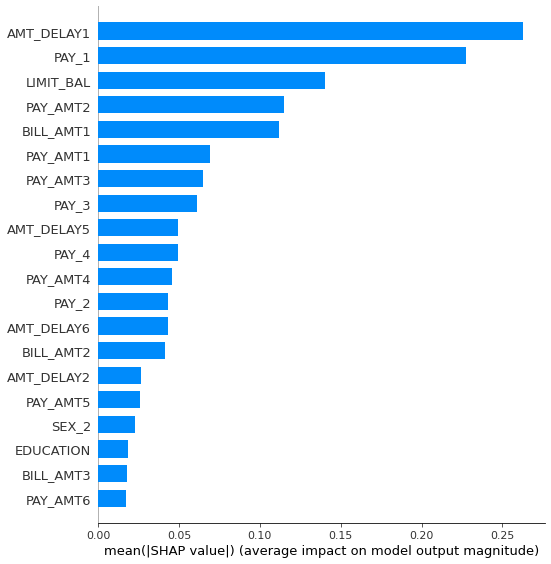

In [35]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

The plot above shows the **global feature importances** by aggregating the absolute SHAP values over all the examples in the train set for each feature. From this plot, we see that `AMT_DELAY1` has the largest mean SHAP value which indicates that it is the most important feature to predict whether the payment will default or not. This is a good sign that feature engineering was useful because `AMT_DELAY1` is an engineered feature. Other important feature include `PAY_1` and `LIMIT_BAL`.

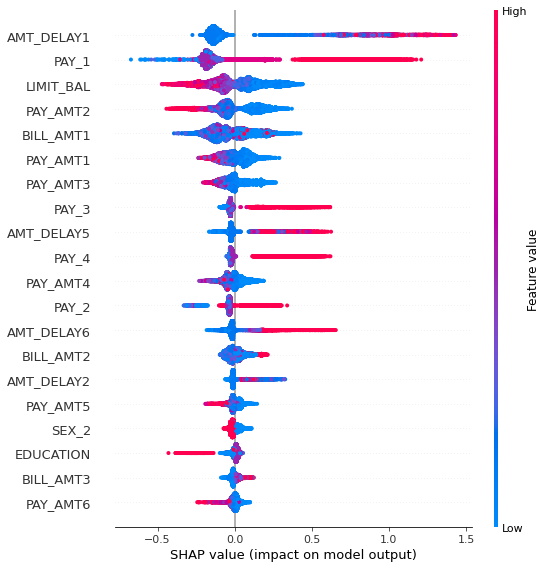

In [36]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc)

The plot above shows the **feature importances** on the x-axis for different features on the y-axis with the feature values encoded in the colour and it also shows the **direction of how features drive predictions**. It is easier to interpret one hot encoded categorical variables because they can only take on a value of 0 or 1. For the feature `SEX_2`, we see that if the feature value is low (i.e. `SEX_2 = 0` meaning that the sex is Male), the SHAP value is positive meaning that it drives the prediction towards a default payment.

On the other hand, for a continuous feature such as `LIMIT_BAL`, low `LIMIT_BAL` values seem to be associated with default payments. This may be because customers who do not have a good credit score are given a lower credit limit, and these customers are also the ones who default the payment.

<br><br>

## 13. Results on the test set

In [37]:
preds = random_search_lgbm.predict(X_test)
soft_preds = random_search_lgbm.predict_proba(X_test)

In [38]:
validation_scores = (results_rs_lgbm.set_index("rank_test_roc_auc")
                     .sort_index().iloc[[0]])

test_results = pd. DataFrame ({
    "LGBM Classifier": ["Test", "Validation", "Train"],
    "accuracy": [random_search_lgbm.score(X_test, y_test),
                 validation_scores["mean_test_accuracy"][1],
                 validation_scores["mean_train_accuracy"][1]],
    "recall": [recall_score(y_test, preds),
               validation_scores["mean_test_recall"][1],
               validation_scores["mean_train_recall"][1]],
    "f1_score": [f1_score(y_test, preds),
                 validation_scores["mean_test_f1"][1],
                 validation_scores["mean_train_f1"][1]],
    "roc_auc": [roc_auc_score(y_test, soft_preds[:, 1]),
                validation_scores["mean_test_roc_auc"][1],
                validation_scores["mean_train_roc_auc"][1]],
    "average_precision": [average_precision_score(y_test, soft_preds[:, 1]),
                          validation_scores["mean_test_average_precision"][1],
                          validation_scores["mean_train_average_precision"][1]]
})

test_results

,LGBM Classifier,accuracy,recall,f1_score,roc_auc,average_precision
0,Test,0.783980,0.367556,0.472451,0.783980,0.542901
1,Validation,0.820381,0.362841,0.474214,0.783001,0.567473
2,Train,0.826607,0.378092,0.493273,0.829643,0.628139


In [39]:
test_df.shape

(9000, 31)

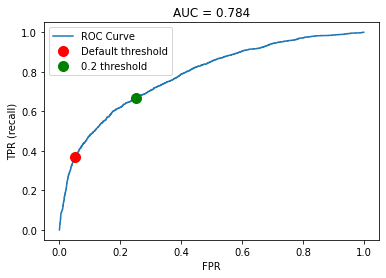

In [40]:
# ROC
fpr, tpr, thresholds = roc_curve(
    y_test,
    random_search_lgbm.predict_proba(X_test)[:, 1]
)

roc_lgbm = roc_auc_score(
    y_test,
    random_search_lgbm.predict_proba(X_test)[:, 1]
)

title = "AUC = " + str(round(roc_lgbm, 3))

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
default_threshold = np.argmin(np.abs(thresholds - 0.5))
threshold_02 = np.argmin(np.abs(thresholds - 0.2))
plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="Default threshold",
)
plt.plot(
    fpr[threshold_02],
    tpr[threshold_02],
    "og",
    markersize=10,
    label="0.2 threshold",
)
plt.legend (loc="best");
plt.title(title);

In [41]:
# Predictions with threshold at 0.2

preds_new = (random_search_lgbm.predict_proba(X_test) > 0.2) [:, 1]

test_results = pd.concat([test_results, pd.DataFrame({
    "LGBM Classifier": "Test with threshold at 0.2",
    "accuracy": sum(y_test == preds_new) / len(y_test),
    "recall": recall_score(y_test, preds_new),
    "f1_score": f1_score(y_test, preds_new),
    "roc_auc": validation_scores["mean_test_roc_auc"][1],
    "average_precision": validation_scores["mean_test_average_precision"][1]},
    index=[2]
)], ignore_index=True, axis=0)

test_results

,LGBM Classifier,accuracy,recall,f1_score,roc_auc,average_precision
0,Test,0.783980,0.367556,0.472451,0.783980,0.542901
1,Validation,0.820381,0.362841,0.474214,0.783001,0.567473
2,Train,0.826607,0.378092,0.493273,0.829643,0.628139
3,Test with threshold at 0.2,0.732000,0.666838,0.518563,0.783001,0.567473


The test scores are similar to the validation scores obtained previously which suggests that our model has **good generalisation**, and that the **optimisation bias is small**. Furthermore, the train and validation scores are similar, which indicates that our model is not overfitting to the training set.

The test set has 9000 examples, which is a moderate number. However, our model only had a recall of 0.369 using the default threshold of 0.5. Lowering the threshold to 0.2 resulted in an increase in the recall by almost two times! However, even then, the recall is only 0.661 which is still quite low. Depending on how much we want to control for the Type-I and Type-II errors, we can change the threshold to fit our needs better.

Since the recall is not very high, our model still fails to identify default payments very well. Thus, we **cannot be overly confident in our model especially on deployment data**. Additionally, the feature importances given by SHAP values are also to be taken with a grain of salt because it is simply what the model has learned and it does not necessarily reflect the real world.

In [42]:
X_train_enc = X_train_enc.round(3)
X_test_enc = X_test_enc.round(3)

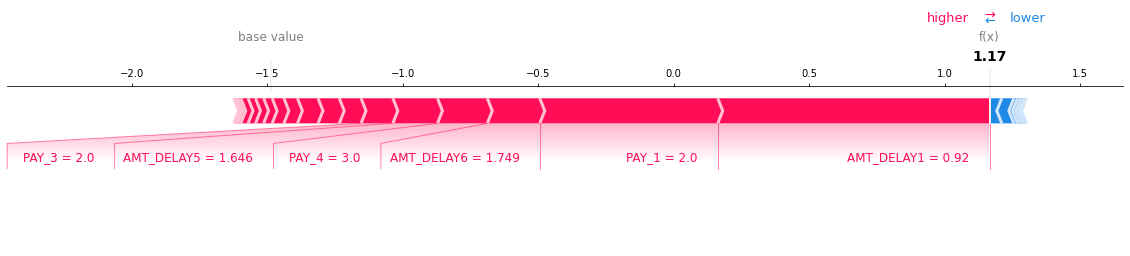

120    1
Name: default, dtype: int64

In [43]:
idx = 10
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][idx, :],
    X_test_enc.iloc[idx, :],
    matplotlib=True
)

y_test.iloc[[idx]]

The force plots above show the SHAP values for different features **when predicting on a specific example**. Features that drive the prediction to the positive class (`default=1`) are shown in red, and features that drive the prediction to the negative class are shown in blue. 

For this example, the true class is 1 (i.e. `default=1`) and the predicted class is also 1 because the model score is higher than the base value. We see that for this example, the features `AMT_DELAY1`, `PAY_1`, `AMT DELAY6`, etc. are all driving the model score in the positive direction which causes the model score to increase. 

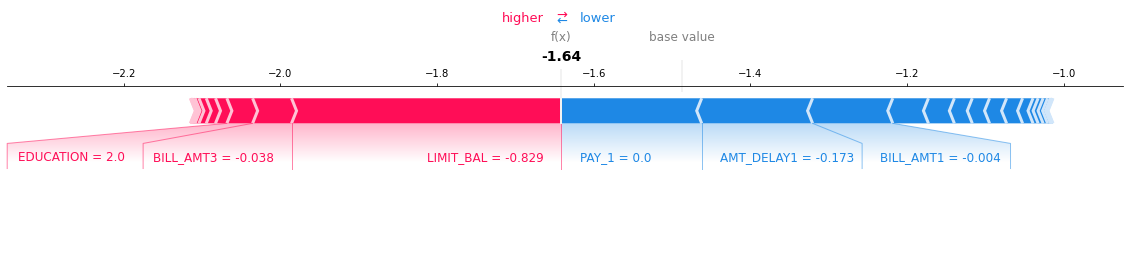

25295    0
Name: default, dtype: int64

In [44]:
idx = 5
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][idx, :],
    X_test_enc.iloc[idx, :],
    matplotlib=True
)

y_test.iloc[[idx]]

For this example, the true class is 0 (i.e. `default=0`) and the predicted class is also 0 because the model score is lower than the base value. We can see how the different features drive the model score in this example. In particular, the features `LIMIT_BAL`, `BILL_AMT3`, and `EDUCATION` drive the model score in the positive direction, while `PAY_1`, `AMT DELAY1`, and `BILL_AMT1`, etc. are driving the model score in the negative direction. The overall effect is that the model score is driven lower than the base value which causes the prediction to be 0. 

<br><br>

## 14. Summary

In [45]:
preds = random_search_lr.predict(X_test)
soft_preds = random_search_lr.predict_proba(X_test)

validation_scores_lr = (results_rs_lr
                        .set_index("rank_test_roc_auc")
                        .sort_index().iloc[[0]])

test_results_lr = pd. DataFrame ({
    "Logistic Regression": ["Test", "Validation", "Train"],
    "accuracy": [random_search_lr.score(X_test, y_test),
                 validation_scores_lr["mean_test_accuracy"][1],
                 validation_scores_lr["mean_train_accuracy"][1]],
    "recall": [recall_score(y_test, preds),
               validation_scores_lr["mean_test_recall"][1],
               validation_scores_lr["mean_train_recall"][1]],
    "f1_score": [f1_score(y_test, preds),
                 validation_scores_lr["mean_test_f1"][1],
                 validation_scores_lr["mean_train_f1"][1]],
    "roc_auc": [roc_auc_score(y_test, soft_preds[:, 1]),
                validation_scores_lr["mean_test_roc_auc"][1],
                validation_scores_lr["mean_train_roc_auc"][1]],
    "average_precision": [average_precision_score(y_test, soft_preds[:, 1]),
                          validation_scores_lr["mean_test_average_precision"][1],
                          validation_scores_lr["mean_train_average_precision"][1]]
})

test_results_lr

,Logistic Regression,accuracy,recall,f1_score,roc_auc,average_precision
0,Test,0.738344,0.635524,0.496491,0.738344,0.500931
1,Validation,0.720286,0.630332,0.501600,0.735765,0.513270
2,Train,0.720226,0.631666,0.502033,0.738055,0.515651


In [46]:
test_results

,LGBM Classifier,accuracy,recall,f1_score,roc_auc,average_precision
0,Test,0.783980,0.367556,0.472451,0.783980,0.542901
1,Validation,0.820381,0.362841,0.474214,0.783001,0.567473
2,Train,0.826607,0.378092,0.493273,0.829643,0.628139
3,Test with threshold at 0.2,0.732000,0.666838,0.518563,0.783001,0.567473


The table shows the scoring metrics for the `LGBMClassifier` and `LogisticRegression` models on the train, validation and test sets. The `LGBMClassifier` with a threshold of 0.2 outperforms the `LogisticRegression` model on all the scoring metrics except accuracy. It is important to remember that this is a spotting classification problem and thus, other scoring metrics such as the recall, f1-score, ROC AUC, and average precision are more informative than the accuracy. The results demonstrate a trade-off between model interpretability and accuracy; although parameters of the `LogisticRegression` model are more easily interpretable, it has a lower accuracy. Furthermore, the `LGBMClassifier` also has longer fit and score times which may affect the decision of which model to choose. 

If it is important for model coefficients to be easily interpretable, and to have a short fit and score time, then the `LogisticRegression` model should be chosen because the difference between the scores is not large. 

However, if the fit and score times are not a concern, then the `LGBMClassifier` model should be chosen because it resulted in better scores. The model parameters can still be interpreted using SHAP values, although it may require more work. 

Both models have a recall of about 0.65 which implies that there is still a moderate amount of false negatives being predicted by the model. If we want to control for the Type-II error very strongly, then during cross-validation, the main scoring metric used can be the recall. 

To further improve on the model's performance, more careful feature selection can be done. In this task, a few interaction terms were included, however, there are still many other features that may interact with one another. Hyperparameter optimisation of more models can also be carried out to determine which model results in the best scores. Similarly, different loss functions and optimisation algorithms can also be explored to find out if they lead to better scores or faster times. More advanced ensemble classifier techniques such as model averaging and stacking can also be explored to make use of all the trained models. 

Implementing all these may result in hitting the validation set many times which implies a higher optimisation bias risk. To lower this risk, methods such as nested cross-validation can also be considered. Finally, the examples where the model is predicting incorrectly can be examined more closely to see whether there are certain features that "mislead" and drive the model in the wrong direction. This may also provide us with some information that can be useful for feature engineering. 

The final test ROC AUC score is 0.783 which comes from the tuned `LGBMClassifier` model. 